
# Strategy 3A: Logic Visualization
**Objective:** Visually verify the Event-Driven State Machine (Unlock -> Zone -> Trigger) on Real Market Data.

## 1. Thesis (Strong Trend Variant)
This implementation of Strategy 3A optimizes for **Strong Trend Continuation**. Unlike mean-reversion systems that wait for deep crosses, this engine targets shallow pullbacks that hold value.

1.  **Unlock:** Price breaks the Opening Range (OR) in the direction of the 5-minute trend.
2.  **Zone (Momentum):** Price pulls back into value but **holds VWAP**.
    * *Longs:* Price tests `[VWAP, +1σ]`.
    * *Shorts:* Price tests `[-1σ, VWAP]`.
3.  **Trigger:** Micro-structure confirms the resumption of the trend.

> **Implementation Note:** The core engine is configured for this "Shallow Pullback" logic to filter out choppy markets. Deep pullbacks (crossing VWAP) are filtered out by the zone definition in `engine.py`.


In [25]:
# 1. Environment Setup
%pip install matplotlib seaborn

import sys
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Add project root to path so we can import 's3a_backtester'
sys.path.append(os.path.abspath("../.."))

from s3a_backtester.data_io import load_minute_df, slice_rth
from s3a_backtester.features import (
    compute_session_refs,
    compute_session_vwap_bands,
    find_swings_1m,
)
from s3a_backtester.structure import trend_5m, micro_swing_break
from s3a_backtester.engine import generate_signals

# Professional Plotting Style
plt.style.use("bmh")
print("Imports Complete.")

Note: you may need to restart the kernel to use updated packages.
Imports Complete.


In [26]:
# 2. Data Loading (12-Month NQ)
# Adjust path if your filename differs slightly (e.g. date range).
DATA_PATH = "../../data/vendor_parquet/NQ/NQ.v.0_2024-12-01_2025-11-30_RTH.parquet"

if not os.path.exists(DATA_PATH):
    print(f"WARNING: {DATA_PATH} not found.")
    print("Falling back to synthetic sample for demonstration...")
    DATA_PATH = "../../data/sample/synth_3d_RTH.parquet"

if os.path.exists(DATA_PATH):
    df = load_minute_df(DATA_PATH, tz="America/New_York")
    df = slice_rth(df)
    print(f"Loaded {len(df)} bars from {DATA_PATH}")

    # Optional: Slice to a smaller window for faster visualization processing
    # df = df.loc["2025-01-01":"2025-01-31"]
    # print(f"Sliced to {len(df)} bars for visualization.")
else:
    raise FileNotFoundError(
        "No data found. Please run 'quickstart.sh' or check vendor_parquet folder."
    )

Loaded 99840 bars from ../../data/vendor_parquet/NQ/NQ.v.0_2024-12-01_2025-11-30_RTH.parquet


In [27]:
# 3. Feature Engineering Pipeline
print("--- Starting Feature Engineering ---")

# A. Session References (OR High/Low)
df = compute_session_refs(df)

# B. VWAP Bands
# compute_session_vwap_bands returns the full DF with new cols
bands_df = compute_session_vwap_bands(df)
df = bands_df.copy()

# EXPLICIT MAPPING: Map library columns to Engine/Plot columns
# This prevents 'KeyError: vwap_1u' downstream
if "band_p1" in df.columns:
    df["vwap_1u"] = df["band_p1"]
    df["vwap_1d"] = df["band_m1"]
    df["vwap_2u"] = df["band_p2"]
    df["vwap_2d"] = df["band_m2"]
    print("✅ VWAP Bands mapped successfully.")
else:
    print(f"❌ WARNING: 'band_p1' not found. Columns: {df.columns.tolist()}")

# C. 5-Minute Trend
df_5m = df.resample("5min", label="right", closed="right").agg(
    {"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"}
)
tr5 = trend_5m(df_5m)
df["trend_5m"] = tr5["trend_5m"].reindex(df.index, method="ffill")

# D. Micro-Structure
sw = find_swings_1m(df)
df["swing_high"] = sw["swing_high"]
df["swing_low"] = sw["swing_low"]
mb = micro_swing_break(df)
df["micro_break_dir"] = mb["micro_break_dir"]

# VERIFICATION
if "vwap_1u" in df.columns:
    print(f"--- Feature Engineering COMPLETE. DF Shape: {df.shape} ---")
else:
    raise RuntimeError("CRITICAL FAILURE: 'vwap_1u' column is missing.")

--- Starting Feature Engineering ---
✅ VWAP Bands mapped successfully.
--- Feature Engineering COMPLETE. DF Shape: (99840, 27) ---


In [28]:
# 4. Generate Signals (The Engine)
# We mock a minimal config to ensure "Production" behavior


class MockConfig:
    class Signals:
        disqualify_after_unlock = True
        zone_touch_mode = "range"
        trigger_lookback_bars = 5

    class Instrument:
        tick_size = 0.25

    class Risk:
        max_stop_or_mult = 1.5


cfg = MockConfig()
signals = generate_signals(df, cfg=cfg)

# Quick Diagnostic
unlocks = signals["or_break_unlock"].sum()
zones = signals["in_zone"].sum()
triggers = signals["trigger_ok"].sum()
print("Engine Run Complete.")
print(f"Unlock Events: {unlocks} | Zone Touches: {zones} | Valid Triggers: {triggers}")

Engine Run Complete.
Unlock Events: 2356 | Zone Touches: 241 | Valid Triggers: 24


Visualizing Target Date: 2024-12-02


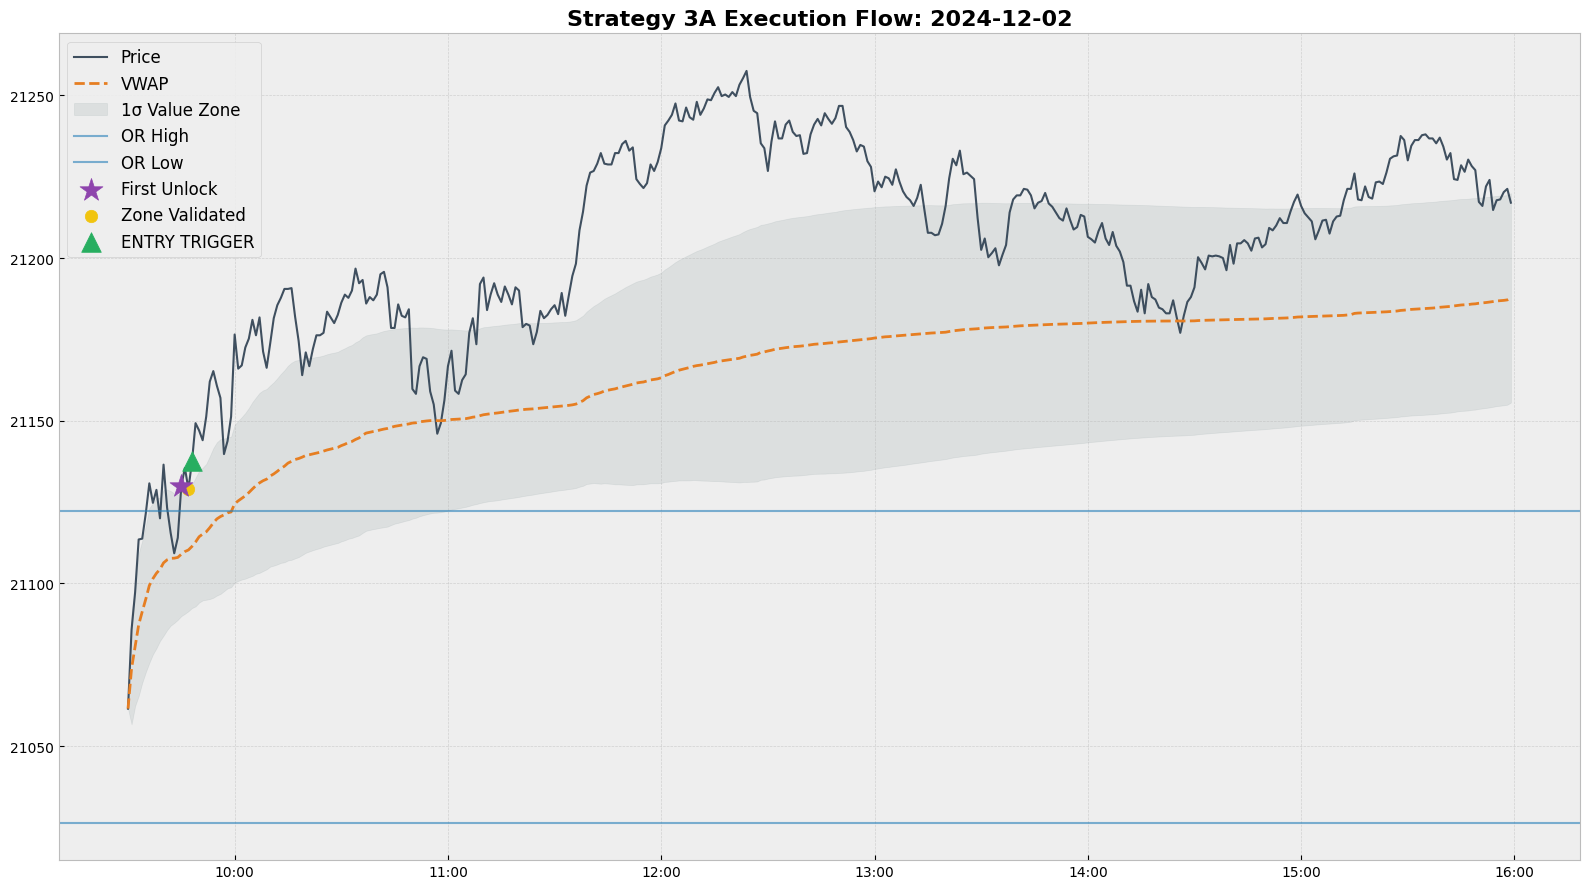

In [29]:
# 5. Visualization: The "Golden Setup"

trigger_days = signals[signals["trigger_ok"].astype(bool)].index.normalize().unique()

if len(trigger_days) > 0:
    # Pick the first day with a valid trade trigger
    TARGET_DATE = str(trigger_days[0].date())
    print(f"Visualizing Target Date: {TARGET_DATE}")

    subset = signals[signals.index.strftime("%Y-%m-%d") == TARGET_DATE].copy()

    fig, ax = plt.subplots(figsize=(16, 9))

    # A. Price & Bands (Darker for readability)
    ax.plot(
        subset.index,
        subset["close"],
        color="#2c3e50",
        alpha=0.9,
        label="Price",
        linewidth=1.5,
    )
    ax.plot(
        subset.index,
        subset["vwap"],
        color="#e67e22",
        linestyle="--",
        linewidth=2,
        label="VWAP",
    )

    # Darker band (alpha 0.1 -> 0.2)
    ax.fill_between(
        subset.index,
        subset["vwap_1u"],
        subset["vwap_1d"],
        color="#95a5a6",
        alpha=0.2,
        label="1σ Value Zone",
    )

    # B. OR Levels
    or_h = subset["or_high"].iloc[-1]
    or_l = subset["or_low"].iloc[-1]
    ax.axhline(
        or_h, color="#2980b9", linestyle="-", linewidth=1.5, alpha=0.6, label="OR High"
    )
    ax.axhline(
        or_l, color="#2980b9", linestyle="-", linewidth=1.5, alpha=0.6, label="OR Low"
    )

    # C. Events
    unlocks = subset[subset["or_break_unlock"].astype(bool)]
    if not unlocks.empty:
        first_unlock = unlocks.iloc[:1]
        ax.scatter(
            first_unlock.index,
            first_unlock["close"],
            color="#8e44ad",
            marker="*",
            s=300,
            label="First Unlock",
            zorder=5,
        )

    # Zone Touch
    zones = subset[subset["in_zone"].astype(bool)]
    ax.scatter(
        zones.index,
        zones["close"],
        color="#f1c40f",
        s=80,
        label="Zone Validated",
        zorder=4,
    )

    # Trigger
    triggers = subset[subset["trigger_ok"].astype(bool)]
    ax.scatter(
        triggers.index,
        triggers["close"],
        color="#27ae60",
        marker="^",
        s=200,
        label="ENTRY TRIGGER",
        zorder=6,
    )

    # D. Formatting
    ax.set_title(
        f"Strategy 3A Execution Flow: {TARGET_DATE}", fontsize=16, fontweight="bold"
    )
    ax.legend(loc="upper left", frameon=True, framealpha=0.9, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=subset.index.tz))
    ax.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.show()
else:
    print("No triggers found in the loaded dataset to visualize.")